In [2]:
#/dtu/3d-imaging-center/projects/2023_DANFIX_103_ECECPMI

In [1]:
import os
import numpy as np
import pickle
import math
import scipy as sp
from scipy import interpolate
from numpy.linalg import solve
import matplotlib.pyplot as plt
from skimage.measure import profile_line
from time import time
import spekpy
import skimage
import copy
import matplotlib
import random

from skimage import color, io, measure, img_as_ubyte, img_as_float
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk 

from cil.io import NikonDataReader, RAWFileWriter, TIFFStackReader, TIFFWriter
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D
from cil.recon import FDK
from cil.plugins.tigre import FBP, ProjectionOperator
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector
from cil.optimisation.algorithms import CGLS, SIRT

from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

from cil.io import NikonDataReader
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D, show1D
from cil.recon import FDK, FBP
from cil.plugins.tigre import ProjectionOperator#, FBP
from cil.processors import TransmissionAbsorptionConverter, AbsorptionTransmissionConverter, Slicer, Normaliser, Padder
from cil.optimisation.algorithms import CGLS, SIRT
from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry
from cil.utilities.noise import gaussian, poisson

print(os.getcwd())
if os.getcwd() == "/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev":
    os.chdir('analysis/s214743_bsc')
    print(os.getcwd())

base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')

from sim_main import fun_attenuation, generate_spectrum, generate_triangle_image, staircase_bhc

from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu

/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from cil.io import NikonDataReader, ZEISSDataReader, RAWFileWriter, TIFFStackReader, TIFFWriter
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D
from cil.recon import FDK
from cil.plugins.tigre import FBP, ProjectionOperator
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.optimisation.algorithms import CGLS, SIRT

from skimage.filters import median, gaussian
from skimage.filters import prewitt_h, prewitt_v, prewitt

In [3]:
path = "/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/raw_data_3DIM/VKH8206-X20 [2022-02-08 10.27.26]/VKH8206-X20_recon.xtekct"
reader = NikonDataReader(file_name=path)

In [4]:
data = reader.read()

In [5]:
print(type(data))
print(data)

<class 'cil.framework.framework.AcquisitionData'>
Number of dimensions: 3
Shape: (1571, 1000, 1000)
Axis labels: ('angle', 'vertical', 'horizontal')



3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -255.77484131,    0.        ]
	Rotation axis position: [0.27062218, 0.        , 0.        ]
	Rotation axis direction: [0.0021087 , 0.        , 0.99999778]
	Detector position: [ -0.        , 855.97315869,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.4 0.4]
	Pixel origin: top-right
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1571
	Angles 0-20 in degrees:
[180.     , 179.77084, 179.54169, 179.31255, 179.08339, 178.85423,
 178.62508, 178.39592, 178.16678, 177.93762, 177.70847, 177.47931,
 177.25015, 177.02101, 176.79185, 176.5627 , 176.33354, 176.10439,
 175.87524, 175.64609]
Distances in units: units distance
Number of channels: 1
channel_spacing: 1.0
voxel_num : x1000,y1000,z1000
voxel_size : x0.09202619345700429,y0.09202619345700429,z0.09202619345700429

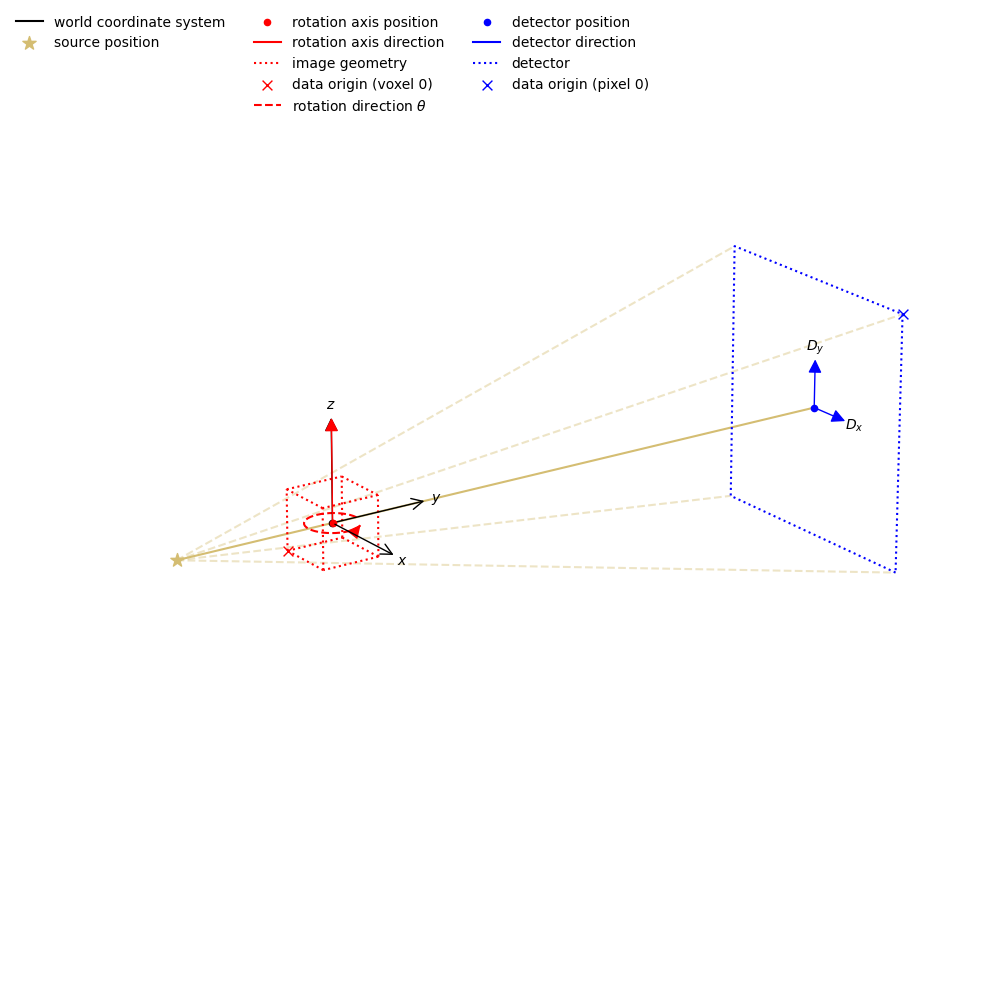

In [6]:
ag = data.geometry
ig = ag.get_ImageGeometry()
print(ag)
print(ig)
show_geometry(ag, ig)

In [7]:
data_sliced = Slicer(roi={'vertical':(100,900)})(data)

In [10]:
islicer(data_sliced, origin='upper-right',direction=0,size=(10,10))

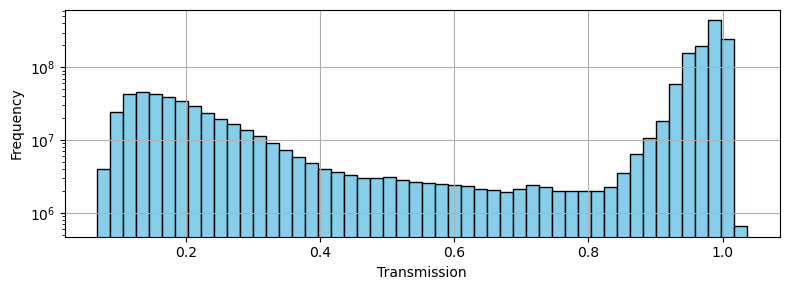

In [26]:
plt.figure(figsize=(8, 3))
# plt.hist(data.as_array()[785,:,:].flatten(), bins=100)
# plt.hist(data.as_array()[1135,:,:].flatten(), bins=100)
plt.hist(data.as_array().flatten(), bins=50, color='skyblue', edgecolor='black')
plt.yscale('log')
plt.grid(True)
plt.xlabel('Transmission')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('plots/X20_raw_hist.pdf')
plt.show()

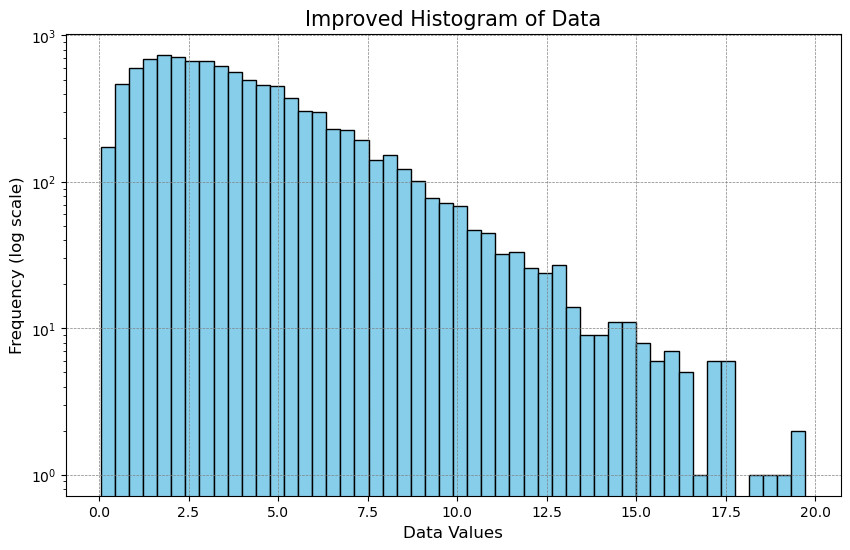

In [18]:
# Sample data generation (replace with your actual data)
data123 = np.random.gamma(shape=2.0, scale=2.0, size=10000)

# Set the size of the figure
plt.figure(figsize=(10, 6))

# Creating histogram with adjustments
n, bins, patches = plt.hist(data123, bins=50, color='skyblue', edgecolor='black')

# Set log scale for the y-axis
plt.yscale('log')

# Adding grid
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Adding labels and title
plt.xlabel('Data Values', fontsize=12)
plt.ylabel('Frequency (log scale)', fontsize=12)
plt.title('Improved Histogram of Data', fontsize=15)

# Show plot
plt.show()


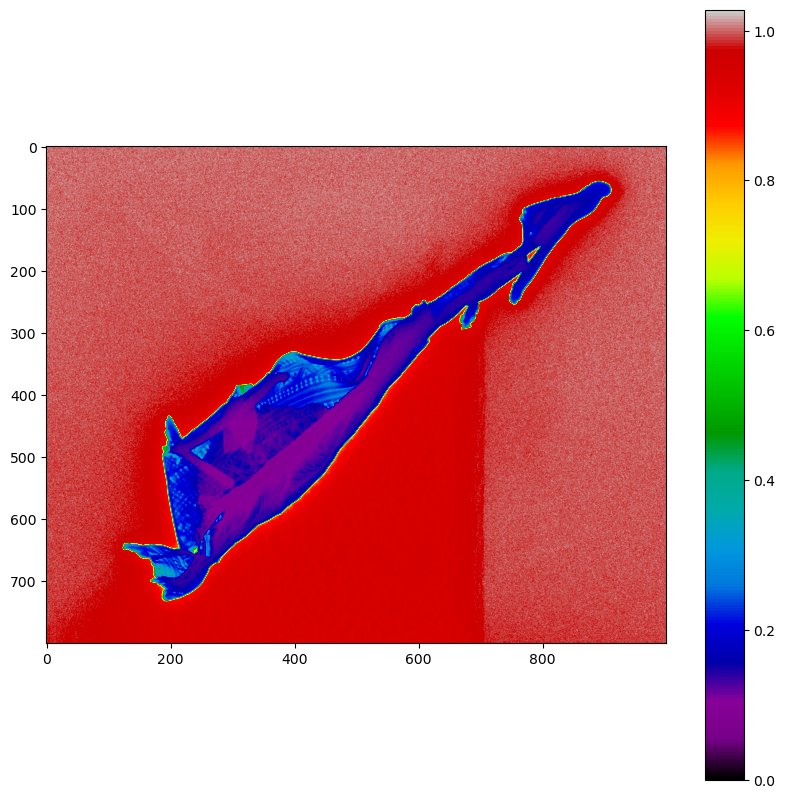

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(data_sliced.as_array()[1135,:,:],cmap='nipy_spectral',vmin=0)
plt.colorbar()

In [8]:
data2 = TransmissionAbsorptionConverter()(data_sliced)

In [14]:
islicer(data2, origin='upper-right',direction=0,size=(10,10))

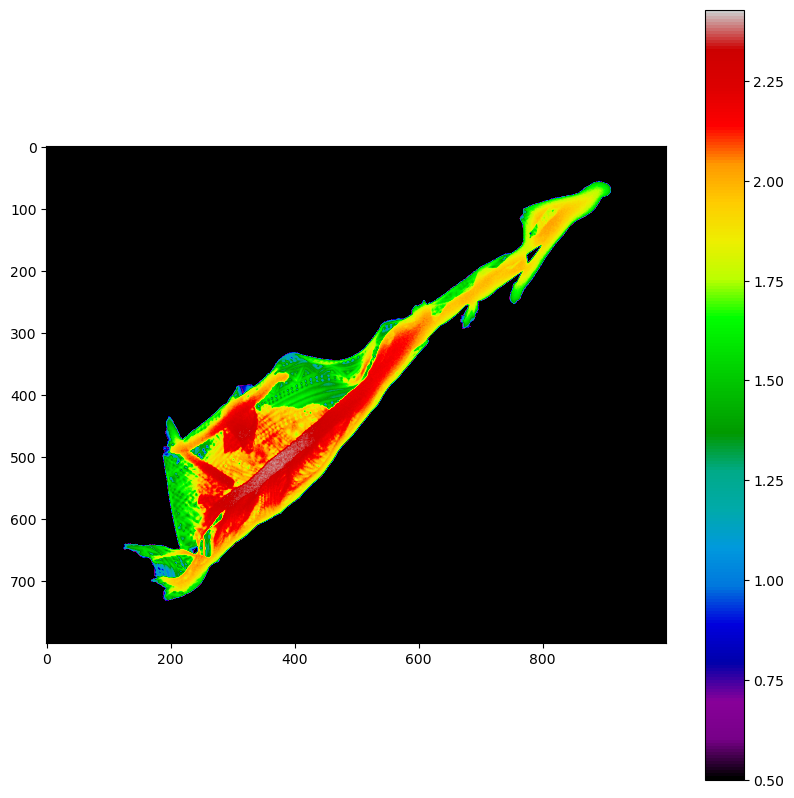

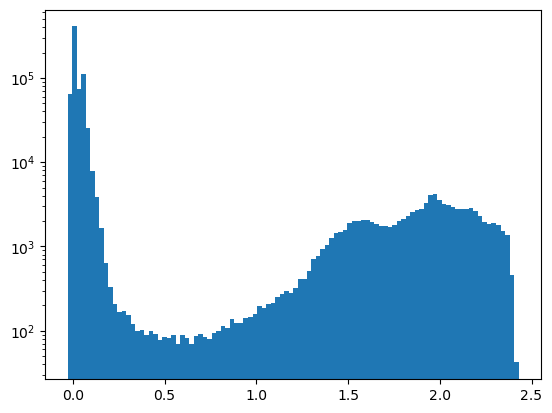

In [13]:
plt.figure(figsize=(10,10))
idx = [1135,785][0]
plt.imshow(data2.as_array()[idx,:,:],cmap='nipy_spectral',vmin=0.5)
# plt.imshow(data2.as_array()[idx,:,:],cmap='nipy_spectral')
plt.colorbar()
plt.figure()
plt.hist(data2.as_array()[idx,:,:].flatten(), bins=100)
# plt.hist(data.as_array().flatten(), bins=100)
plt.yscale('log')
plt.show()

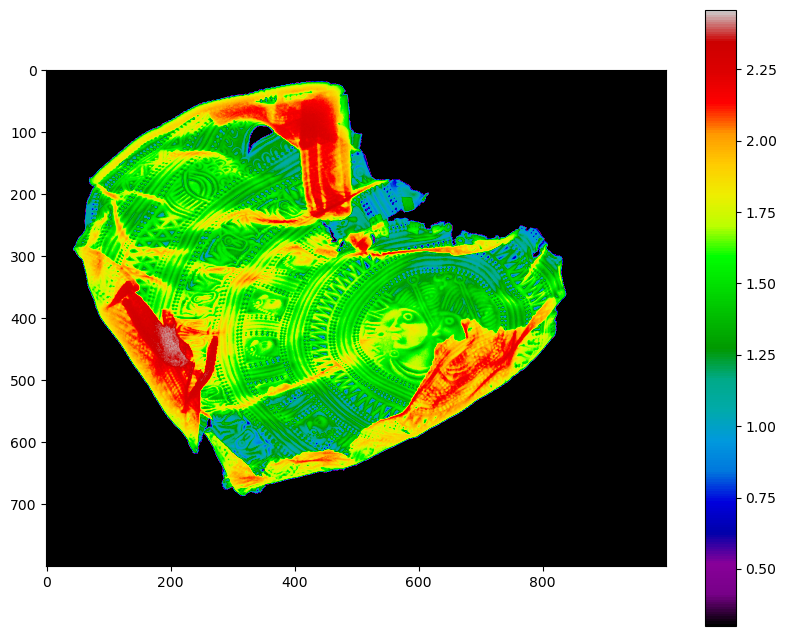

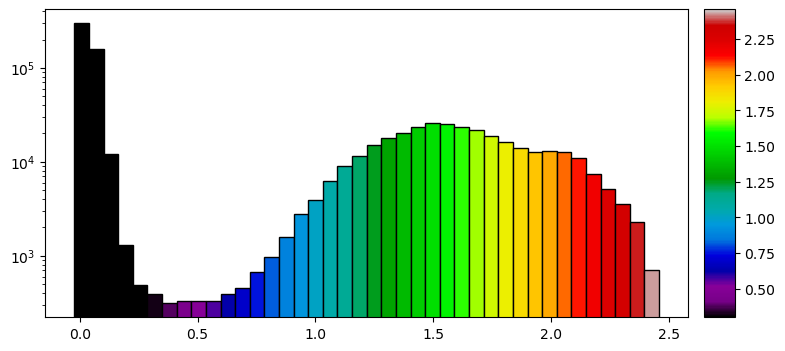

-0.022853564


In [9]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.figure(figsize=(10,8))
idx = [1135,785,1570,1250,1160,500][1]

show_transmission = 0
if show_transmission:
    vmax = 0.5
    proj_slice = data_sliced.as_array()[idx,:,:]
    plt.imshow(proj_slice,cmap='nipy_spectral',vmax=vmax)
else:
    proj_slice = data2.as_array()[idx,:,:]
    vmin = 0.3
    plt.imshow(proj_slice,cmap='nipy_spectral',vmin=vmin)
plt.colorbar()
plt.show()


# Get hist over all data
# proj_slice = data_sliced.as_array()

# Calculate the histogram
# plt.figure(figsize=(10, 4))
num_bins = 40
counts, bin_edges = np.histogram(proj_slice.flatten(), bins=num_bins)

# Calculate the bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Normalize the bin centers to the range [0, 1] for color mapping
# norm = plt.Normalize(bin_centers.min(), bin_centers.max())
if show_transmission:
    norm = plt.Normalize(np.min(proj_slice), vmax)
else:
    norm = plt.Normalize(vmin, np.max(proj_slice))

# Create a color mapping based on the 'nipy_spectral' colormap
cmap = plt.get_cmap('nipy_spectral')

# Plot the histogram bars with the colors based on the bin centers
fig, ax = plt.subplots(figsize=(10,4))
bars = ax.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]), 
              color=cmap(norm(bin_centers)), edgecolor='black')

# Create a ScalarMappable and initialize with the colormap and normalization
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set an empty list to 'fake' the ScalarMappable.

# Add the colorbar using the ScalarMappable
plt.colorbar(sm, ax=ax, pad=0.02, aspect=10)
plt.yscale('log')
# Show the plot
plt.show()
print(np.min(proj_slice))

# plt.figure(figsize=(10, 4))
# plt.hist(data_sliced.as_array()[idx,:,:].flatten(), bins=100)
# plt.yscale('log')
# plt.show()

# Create the histogram and apply the colormap
# num_bins = 20
# n, bins, patches = plt.hist(proj_slice.flatten(), num_bins, density=True, color='blue', edgecolor='black')

# # Create a Normalize object which scales data values to the [0, 1] range
# norm = Normalize(vmin=np.min(proj_slice), vmax=vmax)

# # Create a ScalarMappable and initialize with the colormap
# cmap = plt.get_cmap('nipy_spectral')
# mappable = ScalarMappable(norm=norm, cmap=cmap)

# # Apply the 'nipy_spectral' colormap to the histogram
# for count, patch in zip(n, patches):
#     color = cmap(norm(count))
#     patch.set_facecolor(color)


# # Add the colorbar using the ScalarMappable
# plt.colorbar(mappable, ax=plt.gca())

# plt.show()

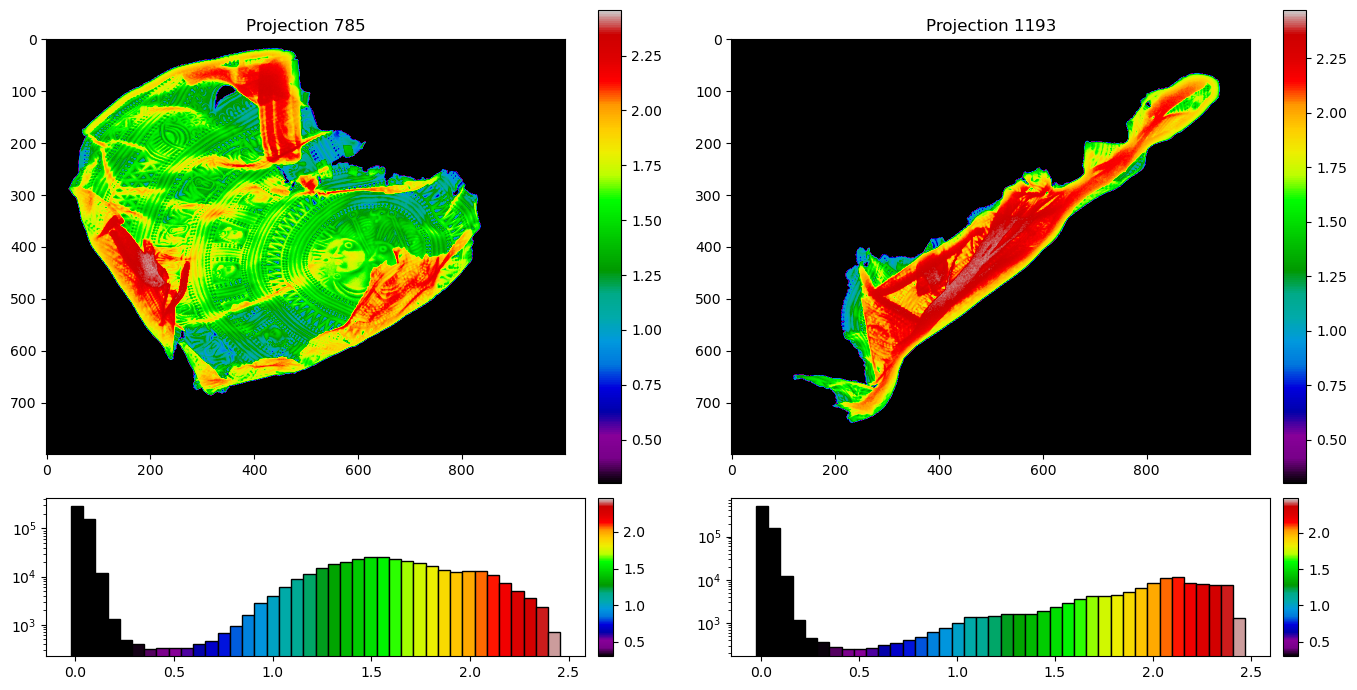

In [28]:
indices = [785,1193]

# Initialize figure with subplots
# figsize=(10,6)
# figsize=(16,10)
figsize=(14,7)
fig, axs = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'height_ratios': [3, 1]})

num_bins = 40
show_transmission = 0

for i, idx in enumerate(indices):
    axs[0,i].set_title(f'Projection {idx}')
    if show_transmission:
        vmax = 0.5
        proj_slice = data_sliced.as_array()[idx, :, :]
        im = axs[0, i].imshow(proj_slice, cmap='nipy_spectral', vmax=vmax)
    else:
        vmin = 0.3
        proj_slice = data2.as_array()[idx, :, :]
        im = axs[0, i].imshow(proj_slice, cmap='nipy_spectral', vmin=vmin)
    fig.colorbar(im, ax=axs[0, i])

    # Calculate the histogram
    counts, bin_edges = np.histogram(proj_slice.flatten(), bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Normalize the bin centers to the range [0, 1] for color mapping
    if show_transmission:
        norm = Normalize(np.min(proj_slice), vmax)
    else:
        norm = Normalize(vmin, np.max(proj_slice))
    
    # Create a color mapping
    cmap = plt.get_cmap('nipy_spectral')
    bars = axs[1, i].bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]), 
                         color=cmap(norm(bin_centers)), edgecolor='black')
    
    # Create a ScalarMappable for the colorbar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axs[1, i], pad=0.02, aspect=10)
    axs[1, i].set_yscale('log')

plt.tight_layout()
plt.savefig('plots/X20_trimmed_cbar.pdf')
plt.show()

In [29]:
recon = FDK(data2).run()

FDK recon

Input Data:
	angle: 1571
	vertical: 800
	horizontal: 1000

Reconstruction Volume:
	vertical: 800
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



In [31]:
# file_path = os.path.join(base_dir, 'bjobs/X20_recon_full')
# with open(file_path, 'wb') as file:
#     pickle.dump(recon, file)

In [30]:
islicer(recon,size=(10,10),direction=0)

In [17]:
ag = data_sliced.geometry
ig = ag.get_ImageGeometry()

In [18]:
tau = -np.log(0.12)
# data_cap = (data2 < tau) * data2.as_array() + (data2 >= tau) * tau
data_cap = (data2 < tau) * data2.as_array() + (data2 >= tau) * 0.05

data_cap = AcquisitionData(array=np.array(data_cap,dtype='float32'),geometry=ag)

In [19]:
recon = FDK(data_cap).run()

FDK recon

Input Data:
	angle: 1571
	vertical: 800
	horizontal: 1000

Reconstruction Volume:
	vertical: 800
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



: 

: 

In [34]:
islicer(recon,size=(10,10),direction=0)

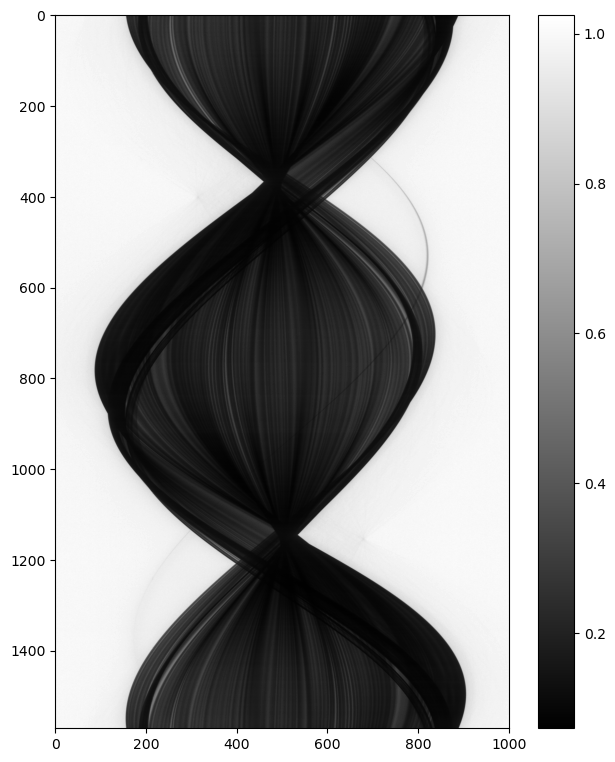

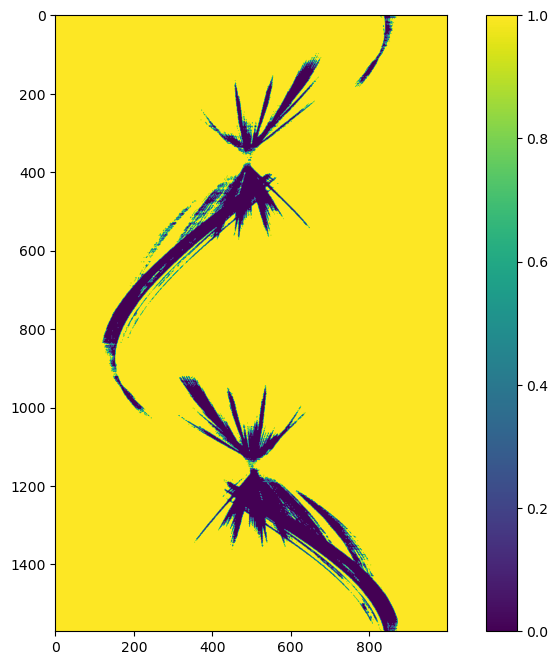

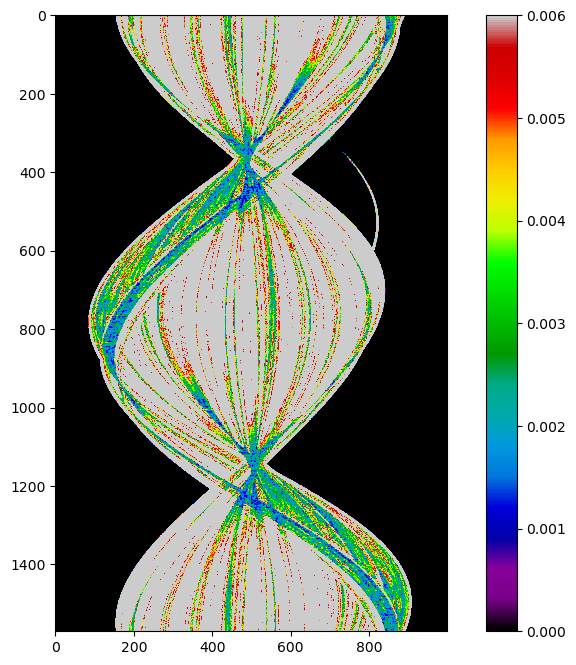

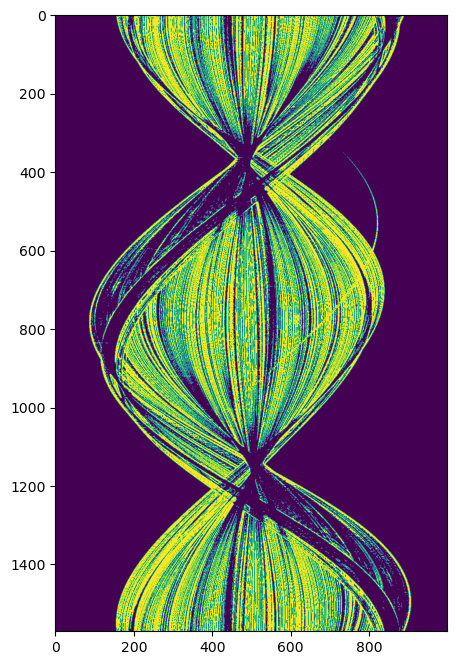

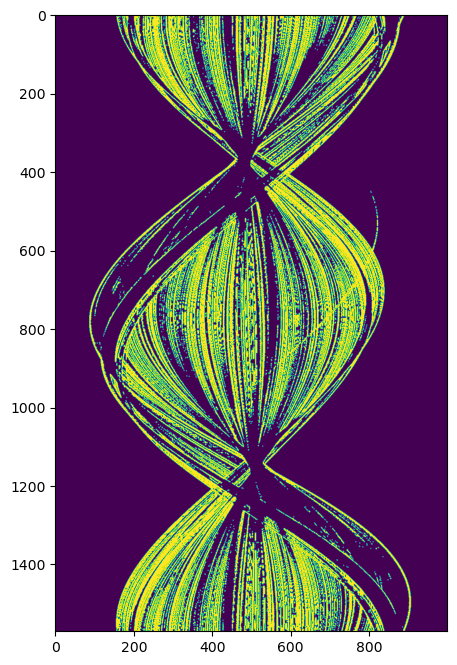

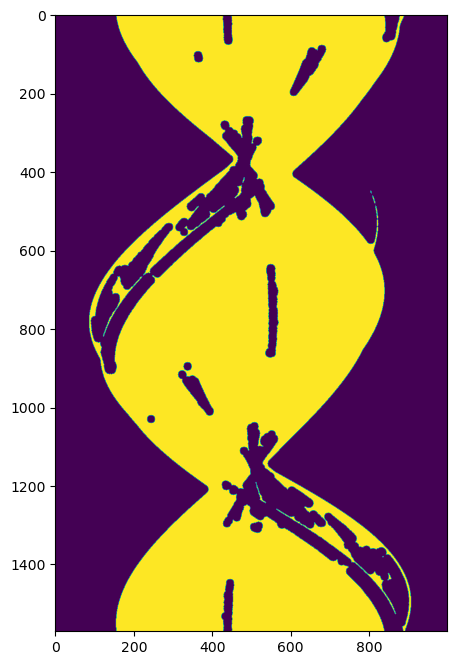

In [114]:
from skimage.morphology import disk

idx = [400,200][0]
proj_slice = data_sliced.as_array()[:,idx,:]
show2D(proj_slice,origin='upper-left')
sino_grad = prewitt(proj_slice)
# tau = 0.01
tau = 0.006

plt.figure(figsize=(10,8))
plt.imshow(proj_slice > 0.11)
plt.colorbar()

plt.figure(figsize=(10,8))
plt.imshow(sino_grad * (proj_slice < 0.8),cmap='nipy_spectral',vmax=tau)
plt.colorbar()

sino1 = (sino_grad > tau) & (proj_slice < 0.8)
plt.figure(figsize=(10,8))
plt.imshow(sino1)

# sino2 = dilation(sino_grad > tau, disk(5))
sino2 = opening(sino1, disk(1))
sino3 = closing(sino2, disk(10))
plt.figure(figsize=(10,8))
plt.imshow(sino2)
plt.figure(figsize=(10,8))
plt.imshow(sino3)

In [16]:
# islicer(data2, origin='upper-right',direction=0,cmap='tab10',size=(10,10))

In [17]:
-np.log(0.14)

1.9661128563728325

In [18]:
recon = FDK(data2).run()

FDK recon

Input Data:
	angle: 1571
	vertical: 800
	horizontal: 1000

Reconstruction Volume:
	vertical: 800
	horizontal_y: 1000
	horizontal_x: 1000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



: 

: 

In [ ]:
# islicer(recon,size=(10,10),direction=0)

In [ ]:
# islicer(recon,size=(10,10),direction=1)

In [ ]:
# plt.hist(data2.as_array().flatten(),bins=100)
# plt.yscale('log')

In [ ]:
def avg_out(path_lengths, data, num_bins):
    x = np.array(path_lengths.as_array().flatten())
    y = np.array(data.as_array().flatten())
    bin_edges = np.linspace(x.min(), x.max(), num_bins+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = np.digitize(x, bin_edges)
    bin_means = np.array([y[bin_indices == i].mean() for i in range(1, len(bin_edges))])
    plt.scatter(x, y, alpha=0.1, color='black', label='Observed',s=2)
    # plt.plot(bin_centers, bin_means, color='red', label='Averaged out')
    plt.plot(bin_centers, bin_means, color='red', marker='o', linestyle='-', label='Averaged out')
    plt.xlabel('Path lengths (mm)')
    plt.ylabel('Absorption')
    plt.legend(loc='lower right')
    plt.show()

    return np.hstack(([0],bin_centers)), np.hstack(([0],bin_means))

def clip_otsu_segment(recon, ig, clip=True, title=''):
    if clip:
        tau = threshold_otsu(np.clip(recon.as_array(),a_min=0,a_max=None))
    else:
        tau = threshold_otsu(recon.as_array())
    
    segmented = ImageData(array=np.array(recon > tau, dtype='float32'), geometry=ig)
    show2D(segmented, title=title)
    return segmented

In [ ]:
A = ProjectionOperator(ig, ag, direct_method='Siddon', device='gpu')

In [ ]:
segmented = clip_otsu_segment(recon, ig, title='Otsu segmentation on initial FDK')

In [ ]:
# islicer(segmented,size=(10,10),direction=1)

In [ ]:
path_lengths = A.direct(segmented)

In [ ]:
avg_out(path_lengths,data2,10)